In [2]:
import pandas as pd
import numpy as np

print("Loading datasets... This may take a moment.")

# --- 1. LOAD DATA ---
# Load the 3 files you downloaded from Kaggle
try:
    train_df = pd.read_csv('data/train.csv')
    weather_df = pd.read_csv('data/weather_train.csv')
    meta_df = pd.read_csv('data/building_metadata.csv')

except FileNotFoundError:
    print("Error: Make sure train.csv, weather_train.csv, and building_metadata.csv")
    print("are in the same folder as this script.")
    exit()

print("Data loaded successfully.")

# --- 2. PRE-PROCESS & MERGE ---

# A) Filter train.csv for *only* electricity (meter=0)
# This makes the file much smaller and matches your project
train_df = train_df[train_df['meter'] == 0]

# B) Merge building metadata with training data
# We add building info (like site_id, primary_use) to the energy data
df = train_df.merge(meta_df, on='building_id', how='left')

# C) Merge weather data
# We add weather info (like temp, humidity) to the main data
# We merge on both 'site_id' and 'timestamp'
df = df.merge(weather_df, on=['site_id', 'timestamp'], how='left')

print("Files merged successfully.")

# --- 3. RENAME COLUMNS (To match your project plan) ---
df = df.rename(columns={
    'meter_reading': 'energy_kWh',
    'air_temperature': 'temperature',
    'dew_temperature': 'humidity', # We'll use dew_temp as a proxy for humidity
    'primary_use': 'building_type'
})

# --- 4. FEATURE ENGINEERING (Create features from your plan) ---
print("Engineering new features...")

# Convert timestamp to datetime object to extract features
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create time features
df['day_of_week'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour

# Create 'time_of_day' feature
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'
df['time_of_day'] = df['hour'].apply(get_time_of_day)

# *** THIS IS THE KEY PART ***
# Engineer 'no_of_people' (occupancy) based on rules
# We create rules based on building type and time of day
def estimate_occupancy(row):
    # Rule 1: Weekends (low occupancy for non-residential)
    if row['day_of_week'] in ['Saturday', 'Sunday']:
        if 'Residential' in row['building_type']:
            return np.random.randint(50, 100) # Higher on weekends
        else:
            return np.random.randint(0, 10) # Low for Office, Education
    
    # Rule 2: Night time (low occupancy)
    if row['time_of_day'] == 'Night':
        if 'Residential' in row['building_type']:
            return np.random.randint(70, 100) # High (sleeping)
        else:
            return np.random.randint(0, 5) # Empty

    # Rule 3: Weekday Day time (Morning, Afternoon, Evening)
    if row['building_type'] in ['Office', 'Education', 'Entertainment']:
        if row['time_of_day'] in ['Morning', 'Afternoon']:
             return np.random.randint(80, 100) # High
        else: # Evening
             return np.random.randint(20, 50) # Medium
    
    # Default for other types
    return np.random.randint(10, 30)

# Apply the rules to create the 'no_of_people' column
# This is slow, so we'll just take a sample to speed it up.
# FOR YOUR PROJECT: You might want to run this on all data
# For speed, let's just use the first 500k rows
df_sample = df.head(500000).copy()

print("Estimating occupancy... (This is the slowest step)")
df_sample['no_of_people'] = df_sample.apply(estimate_occupancy, axis=1)

# --- 5. FINAL CLEANUP & SAVE ---
print("Cleaning and saving final dataset...")

# Select only the columns you need for your project
final_columns = [
    'timestamp',
    'building_id',
    'energy_kWh',
    'temperature',
    'humidity',
    'no_of_people',
    'day_of_week',
    'time_of_day',
    'building_type',
    'square_feet'
]

# Keep only the columns that exist (in case some were missing)
final_columns_exist = [col for col in final_columns if col in df_sample.columns]
final_df = df_sample[final_columns_exist]

# Drop any rows with missing data
final_df = final_df.dropna()

# Save the final, clean dataset
final_df.to_csv('final_project_dataset.csv', index=False)

print("\n--- SUCCESS! ---")
print(f"File 'final_project_dataset.csv' is ready.")
print("It has shape:", final_df.shape)
print("\nHead of your new dataset:")
print(final_df.head())

Loading datasets... This may take a moment.
Data loaded successfully.
Files merged successfully.
Engineering new features...
Estimating occupancy... (This is the slowest step)
Cleaning and saving final dataset...

--- SUCCESS! ---
File 'final_project_dataset.csv' is ready.
It has shape: (490634, 10)

Head of your new dataset:
   timestamp  building_id  energy_kWh  temperature  humidity  no_of_people  \
0 2016-01-01            0         0.0         25.0      20.0             0   
1 2016-01-01            1         0.0         25.0      20.0             2   
2 2016-01-01            2         0.0         25.0      20.0             0   
3 2016-01-01            3         0.0         25.0      20.0             4   
4 2016-01-01            4         0.0         25.0      20.0             0   

  day_of_week time_of_day building_type  square_feet  
0      Friday       Night     Education         7432  
1      Friday       Night     Education         2720  
2      Friday       Night     Educatio

In [5]:
print("\n--- PREPARING TEST DATA ---")

# Load test and weather data
print("\n--- PREPARING TEST DATA ---")

# Load smaller portions for development
test_df = pd.read_csv('data/test.csv', nrows=200000)
weather_test_df = pd.read_csv('data/weather_test.csv', nrows=200000)
meta_df = pd.read_csv('data/building_metadata.csv')


# Filter only electricity meter (meter=0)
test_df = test_df[test_df['meter'] == 0]

# Merge metadata and weather
test_merged = test_df.merge(meta_df, on='building_id', how='left')
test_merged = test_merged.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')

# Rename columns to match training data
test_merged = test_merged.rename(columns={
    'air_temperature': 'temperature',
    'dew_temperature': 'humidity', # proxy
    'primary_use': 'building_type'
})

# Convert timestamp
test_merged['timestamp'] = pd.to_datetime(test_merged['timestamp'])
test_merged['day_of_week'] = test_merged['timestamp'].dt.day_name()
test_merged['hour'] = test_merged['timestamp'].dt.hour

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'
test_merged['time_of_day'] = test_merged['hour'].apply(get_time_of_day)

# Estimate occupancy (same function you used earlier)
test_merged['no_of_people'] = test_merged.apply(estimate_occupancy, axis=1)

# Select same final columns (minus target)
test_final = test_merged[[
    'timestamp',
    'building_id',
    'temperature',
    'humidity',
    'no_of_people',
    'day_of_week',
    'time_of_day',
    'building_type',
    'square_feet'
]]

test_final = test_final.dropna()

test_final.to_csv('final_test_dataset.csv', index=False)
print("\n✅ Test dataset ready and saved as final_test_dataset.csv")
print("Shape:", test_final.shape)
print(test_final.head())



--- PREPARING TEST DATA ---

--- PREPARING TEST DATA ---

✅ Test dataset ready and saved as final_test_dataset.csv
Shape: (162791, 9)
   timestamp  building_id  temperature  humidity  no_of_people day_of_week  \
0 2017-01-01            0         17.8      11.7             4      Sunday   
1 2017-01-01            1         17.8      11.7             8      Sunday   
2 2017-01-01            2         17.8      11.7             9      Sunday   
3 2017-01-01            3         17.8      11.7             5      Sunday   
4 2017-01-01            4         17.8      11.7             3      Sunday   

  time_of_day building_type  square_feet  
0       Night     Education         7432  
1       Night     Education         2720  
2       Night     Education         5376  
3       Night     Education        23685  
4       Night     Education       116607  


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor  # <-- We import XGBoost
from sklearn.metrics import r2_score
import numpy as np
import time
import joblib

print("Loading dataset...")
# --- 1. LOAD DATA ---
try:
    df = pd.read_csv('final_project_dataset.csv')
except FileNotFoundError:
    print("Error: 'final_project_dataset.csv' not found.")
    exit()

df_sample = df.sample(n=50000, random_state=42)
print(f"Loaded {len(df_sample)} random samples for training.")

# --- 2. DEFINE FEATURES (X) AND TARGET (y) ---
X = df_sample.drop(['energy_kWh', 'timestamp'], axis=1) 
y = df_sample['energy_kWh']

# --- 3. PRE-PROCESSING ---
# We use the *faster* preprocessor: 'passthrough' for numbers
# 'OneHotEncoder' for text. This is perfect for all 3 models.

numeric_features = ['temperature', 'humidity', 'no_of_people', 'square_feet']
categorical_features = ['building_id', 'day_of_week', 'time_of_day', 'building_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features), # No scaling needed for trees
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# --- 4. SPLIT THE DATA ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split into training and testing sets.")

# --- 5. DEFINE THE MODELS TO COMPARE ---
# These are the top 3 contenders from your paper + XGBoost
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# --- 6. TRAIN AND EVALUATE ALL MODELS ---
best_model = None
best_score = -np.inf

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    start_time = time.time()
    
    # Create the full pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    end_time = time.time()
    
    print(f"R-squared (R²) Score: {r2:.4f}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    
    # Check if this is the best model so far
    if r2 > best_score:
        best_score = r2
        best_model = pipeline
        best_model_name = name

# --- 7. SAVE THE *BEST* MODEL ---
print("\n--- FINAL RESULT ---")
print(f"The best performing model was: {best_model_name}")
print(f"It had an R² score of: {best_score:.4f}")

# Save the winning model for your Flask API
joblib.dump(best_model, 'energy_model.joblib')
print(f"\nBest model ({best_model_name}) saved as 'energy_model.joblib'.")

Loading dataset...
Loaded 50000 random samples for training.
Data split into training and testing sets.

--- Training RandomForest ---
R-squared (R²) Score: 0.9764
Time taken: 59.68 seconds

--- Training ExtraTrees ---
R-squared (R²) Score: 0.9743
Time taken: 177.64 seconds

--- Training XGBoost ---
R-squared (R²) Score: 0.9438
Time taken: 1.37 seconds

--- FINAL RESULT ---
The best performing model was: RandomForest
It had an R² score of: 0.9764

Best model (RandomForest) saved as 'energy_model.joblib'.


In [19]:
# --- Evaluate model accuracy on training/validation data ---
import pandas as pd
import joblib
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print("🔹 Loading training data for accuracy check...")

# Load the same dataset you used for training
train_data = pd.read_csv("final_project_dataset.csv")  # or whatever your file is named
model = joblib.load("energy_model.joblib")

# Define the same features and target
feature_columns = [
    'temperature', 'humidity', 'no_of_people', 'square_feet',
    'building_id', 'day_of_week', 'time_of_day', 'building_type'
]
X = train_data[feature_columns]
y = train_data['energy_kWh']

# Predict on training data (or you can split 80/20 if you want)
y_pred_train = model.predict(X)

# Compute metrics
r2 = r2_score(y, y_pred_train)
mae = mean_absolute_error(y, y_pred_train)
rmse = np.sqrt(mean_squared_error(y, y_pred_train))

print("\n📈 RandomForestRegressor Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


🔹 Loading training data for accuracy check...

📈 RandomForestRegressor Performance:
R² Score: 0.9668
MAE: 16.5463
RMSE: 59.3057


In [24]:
model.named_steps.keys()


dict_keys(['preprocessor', 'model'])

In [27]:
final_model = model.named_steps['random_forest']
preprocessor = model.named_steps['preprocessor']


KeyError: 'random_forest'

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Step 1: Extract the trained model from pipeline
final_model = model.named_steps['random_forest']
preprocessor = model.named_steps['preprocessor']
  # replace 'regressor' with actual key name (e.g. 'xgb', 'rf', etc.)

# ✅ Step 2: Get feature names from preprocessing
# preprocessor = model.named_steps['preprocessor']  # replace if your pipeline uses a different name
encoded_features = preprocessor.get_feature_names_out(feature_columns)

# ✅ Step 3: Get importances
importances = final_model.feature_importances_

# ✅ Step 4: Sort and visualize top N
feat_imp = pd.DataFrame({
    'Feature': encoded_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

# ✅ Step 5: Plot
plt.figure(figsize=(8,5))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='teal')
plt.title("Top 15 Important Features in Energy Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()


KeyError: 'random_forest'

🔹 Loading model and test dataset...
✅ Model and test data loaded successfully!
⚠️ Actual 'energy_kWh' column not found — skipping accuracy metrics.

✅ Predictions saved as 'test_predictions.csv'


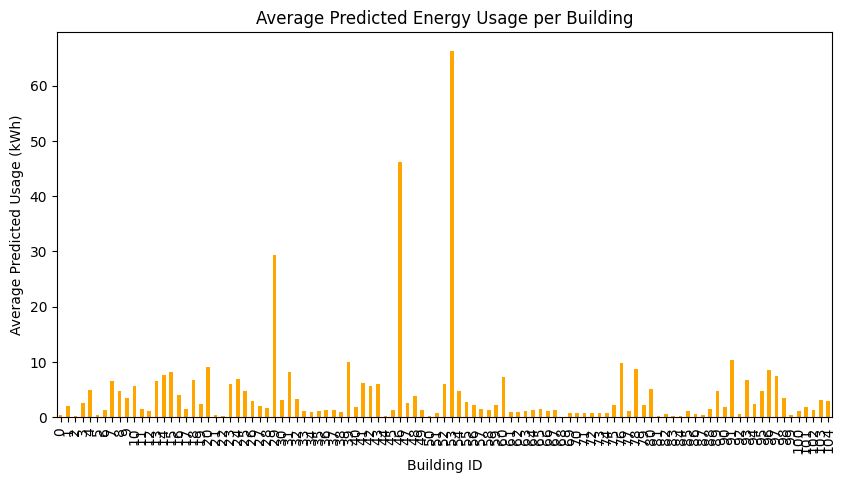


⚠️ 5605 anomalies detected (usage spikes).


,building_id,timestamp,predicted_energy_kWh
29,29,2017-01-01 00:00:00,36.547659
46,46,2017-01-01 00:00:00,40.761126
53,53,2017-01-01 00:00:00,110.049400
76,76,2017-01-01 00:00:00,37.088470
151,46,2017-01-01 01:00:00,41.801353
158,53,2017-01-01 01:00:00,109.665000
181,76,2017-01-01 01:00:00,33.063670
256,46,2017-01-01 02:00:00,41.854592
286,76,2017-01-01 02:00:00,35.953840
361,46,2017-01-01 03:00:00,41.584298


In [13]:
# --- Step 1: Import libraries ---
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print("🔹 Loading model and test dataset...")

# --- Step 2: Load saved model and test data ---
model = joblib.load("energy_model.joblib")
test_data = pd.read_csv("final_test_dataset.csv")

print("✅ Model and test data loaded successfully!")

# --- Step 3: Preprocess timestamp and extract useful time features ---
if 'timestamp' in test_data.columns:
    test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
    test_data['hour'] = test_data['timestamp'].dt.hour
    test_data['weekday'] = test_data['timestamp'].dt.weekday
    test_data['month'] = test_data['timestamp'].dt.month

# --- Step 4: Use the same features as the training model ---
# (Based on your training code)
feature_columns = [
    'temperature', 'humidity', 'no_of_people', 'square_feet',
    'building_id', 'day_of_week', 'time_of_day', 'building_type'
]

# Check for missing columns
missing_cols = [col for col in feature_columns if col not in test_data.columns]
if missing_cols:
    print(f"⚠️ Missing columns in test data: {missing_cols}")

# Prepare valid test data (drop rows with NaNs in feature columns)
X_test = test_data[feature_columns].dropna().copy()
valid_idx = X_test.index

# --- Step 5: Make predictions ---
y_pred = model.predict(X_test)

# Assign predictions only to valid rows
test_data.loc[valid_idx, 'predicted_energy_kWh'] = y_pred

# --- Step 6: Evaluate accuracy if actual values exist ---
if 'energy_kWh' in test_data.columns:
    y_true = test_data.loc[valid_idx, 'energy_kWh']

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print("\n📊 Model Evaluation on Test Data:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
else:
    print("⚠️ Actual 'energy_kWh' column not found — skipping accuracy metrics.")

# --- Step 7: Save predictions ---
test_data.to_csv("test_predictions.csv", index=False)
print("\n✅ Predictions saved as 'test_predictions.csv'")

# --- Step 8: Plot Actual vs Predicted Energy Usage ---
if 'energy_kWh' in test_data.columns:
    plt.figure(figsize=(12,6))
    plt.plot(test_data.loc[valid_idx, 'timestamp'], y_true, color='green', label='Actual Energy Usage')
    plt.plot(test_data.loc[valid_idx, 'timestamp'], y_pred, color='blue', alpha=0.7, label='Predicted Energy Usage')
    plt.title("Actual vs Predicted Energy Consumption Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Step 9: Average Predicted Energy Usage per Building ---
avg_usage = test_data.groupby('building_id')['predicted_energy_kWh'].mean()
avg_usage.plot(kind='bar', figsize=(10,5), color='orange')
plt.title("Average Predicted Energy Usage per Building")
plt.xlabel("Building ID")
plt.ylabel("Average Predicted Usage (kWh)")
plt.show()

# --- Step 10: Simple Anomaly Detection ---
threshold = test_data['predicted_energy_kWh'].mean() + 2 * test_data['predicted_energy_kWh'].std()
anomalies = test_data[test_data['predicted_energy_kWh'] > threshold]

print(f"\n⚠️ {len(anomalies)} anomalies detected (usage spikes).")
display(anomalies[['building_id', 'timestamp', 'predicted_energy_kWh']].head(10))


In [15]:
import pandas as pd

# Load your test dataset
df = pd.read_csv("final_test_dataset.csv")

# Check unique building types
if 'building_id' in df.columns:
    print("Unique building types:", df['building_id'].nunique())
    print("Building types are:", df['building_id'].unique())
else:
    print("No 'building_type' column found in the dataset.")


Unique building types: 105
Building types are: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]


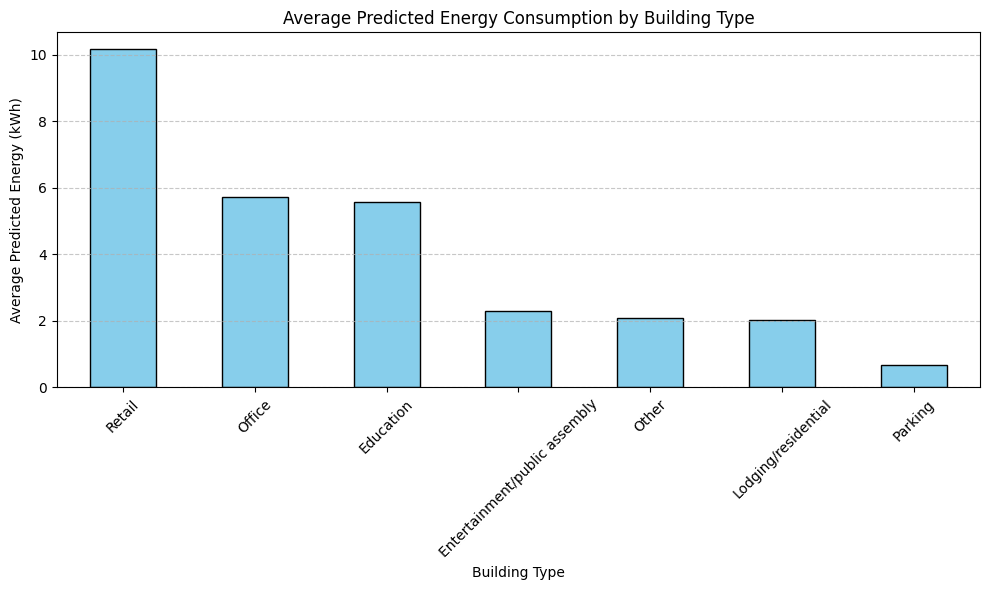

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predictions (your test_predictions.csv)
data = pd.read_csv("test_predictions.csv")

# Group by building type and calculate average predicted energy
energy_by_type = data.groupby('building_type')['predicted_energy_kWh'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
energy_by_type.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Predicted Energy Consumption by Building Type")
plt.xlabel("Building Type")
plt.ylabel("Average Predicted Energy (kWh)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
